In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()

# Na channels: recovery from inactivation

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Na channel recordings in the "data/Na_channels" folder

In [2]:
data_folder = "data/Na_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/Na_channels


['data/Na_channels/nav18-iv.abf',
 'data/Na_channels/nav18-ssinact.abf',
 'data/Na_channels/nav18-nav_recovery.abf']

Choose which file you want to analyze and past the file name here:

In [3]:
data_file = 'data/Na_channels/nav18-nav_recovery.abf'

Now we can load the file and plot the raw data:

Data dimensions (sweeps, channels, timepoints): 
(30, 2, 5160)
sampling freq: 49999.99999999999 Hz


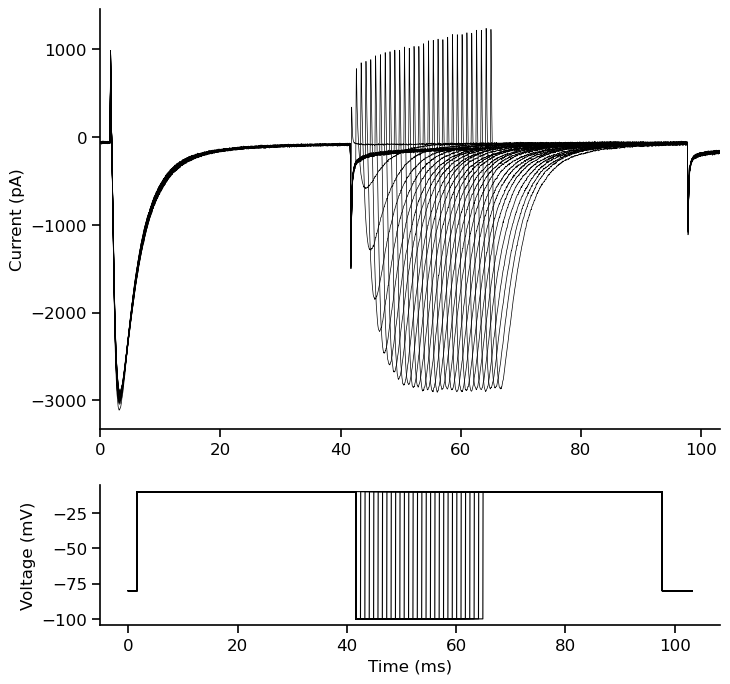

In [4]:
## Extract the sweeps, time and sampling frequency:
sweeps, sweeps_time, sampling_freq = get_sweeps(data_file)

print(f"Data dimensions (sweeps, channels, timepoints): \n{sweeps.shape}")
print(f"sampling freq: {sampling_freq} Hz")

current_traces = sweeps[:, 0, :]
voltage_traces = sweeps[:, 1, :]
ax = plot_traces(sweeps_time, current_traces, voltage_traces)
plt.show()

## 2. Select what you want to measure

### 2.1. Defining the time window

First let's define the relevant time window where we want to measure the currents:

(If you want to save the images, you can do it by clicking on the save icon in the top-right of the image when you hover over it)

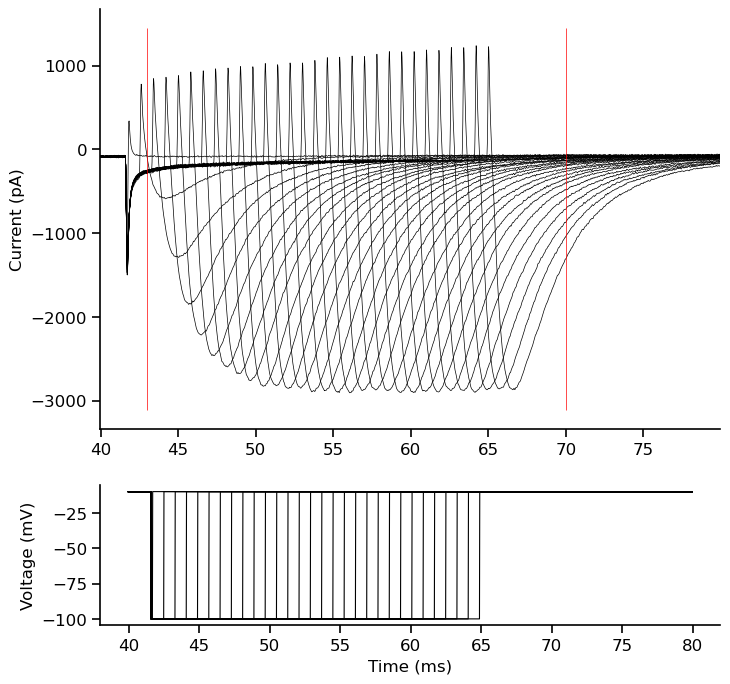

In [5]:
# The start/end time just helps to zoom in on the traces.
start_time = 40  # milliseconds
end_time = 80   # milliseconds, (enter -1 to get the end of the sweep)

# The markers are important: they will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 43  # milliseconds
marker_2 = 70    # milliseconds

current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)

ax = plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)
plt.show()

### 3.1. Optional: apply baseline correction

If your baseline current is not zero, you may need to correct for that to get accurate measurements.

Uncomment this cell block (highlight everything, then cmd+/ on macOS or ctrl+/ on Windows) to run it.

In [ ]:
# # Measure baseline: you need to specify which part of the trace you want to use for baseline measurement.
# start_time = 0 # milliseconds
# end_time = 0.5 # milliseconds
# measurement_type = 'mean' # Options: 'mean', 'max', 'min'

# baseline_voltage, baseline_current = get_step_measurements(sweeps, sweeps_time, start_time, end_time, sampling_freq, measurement_type)

# # Subtract baseline from the sweeps
# num_traces = sweeps.shape[0]
# for i in range(num_traces):
#     sweeps[i,0] -= baseline_current[i]

### 3.2. Measure currents

Here we will be using the timepoints from the markers we defined above to measure the inactivation currents

In [7]:
start_time = marker_1 # milliseconds
end_time = marker_2 # milliseconds
measurement_type = 'min' # Options: 'mean', 'max', 'min', 'peak'

# Get the current steps in the selected time window
_, current_steps = get_step_measurements(sweeps, sweeps_time, start_time, end_time, sampling_freq, measurement_type)

### 3.3. Get the baseline current to normalize against

We want to measure the current at the initial pulse to use as a reference for the inactivation current


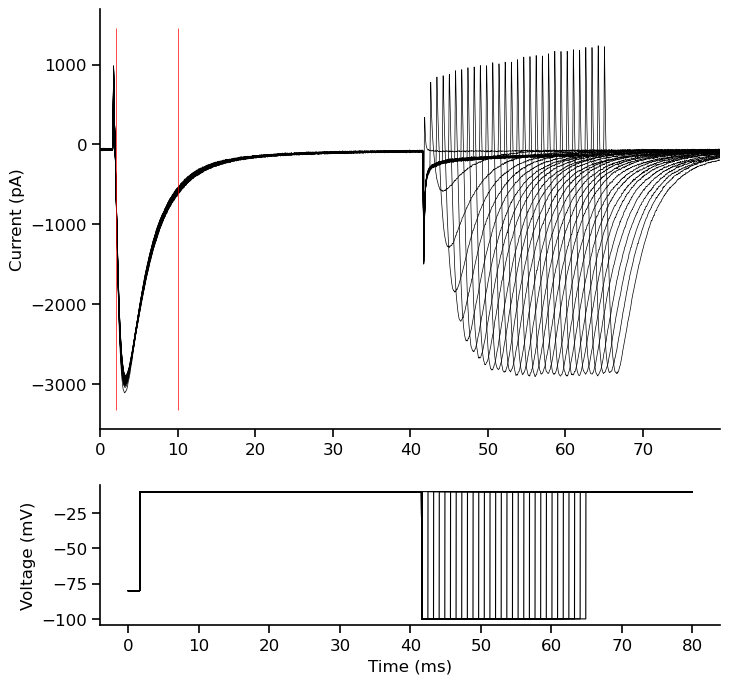

In [8]:
# The start/end time just helps to zoom in on the traces.
start_time = 0 # milliseconds
end_time = 80 # milliseconds

# The markers are important: they will define the window where we actually exctract peak current values from. Set them carefully.
marker_4 = 2 # milliseconds
marker_5 = 10 # milliseconds
measurement_type = 'min' # Options: 'mean', 'max', 'min', 'peak'


current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)
_, baseline_current_steps = get_step_measurements(sweeps, sweeps_time, start_time=marker_4, end_time=marker_5,
                                                  sampling_freq=sampling_freq, measurement_type=measurement_type)

# Normalize the previously measure currents to the baseline currents
current_steps_norm = current_steps / baseline_current_steps

plot_traces(time_in_window, current_traces, voltage_traces, marker_4, marker_5)
plt.show()

### 3.4. Plot the channel recovery curve

Here we will need to manually define the recovery time points based on our protocol.

Tau: 15.39 ms


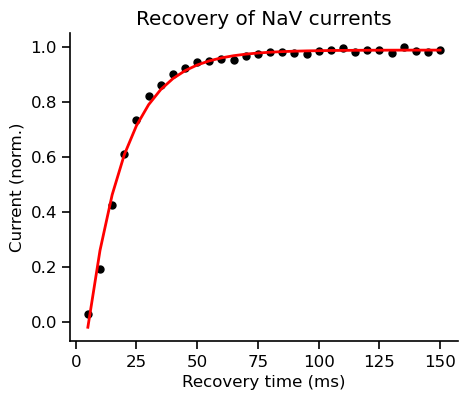

In [ ]:
# Define the delta t delays for the recovery
interval_step = 5    # milliseconds

end = interval_step*(len(current_steps_norm)+1)
recovery_time = np.arange(interval_step, end, interval_step)  # in milliseconds

# Plot the normalized current steps against the holding voltages
fig,ax = plt.subplots(figsize=(5, 4))
ax.plot(recovery_time, current_steps_norm, 'o', color='black', markersize=5)
ax.set_xlabel('Recovery time (ms)')
ax.set_ylabel('Current (norm.)')
ax.set_title('Recovery of NaV currents')

# Fit exponential curve to the data to get the time constant
from scipy.optimize import curve_fit
def exponential_curve(time, V0, tau, V_inf):
    return V0 * np.exp(-time / tau) + V_inf
V0_guess = 0 
Vinf_guess = 1
tau_guess = 20 # ms
p0 = [V0_guess, tau_guess, Vinf_guess]
popt, _ = curve_fit(exponential_curve, recovery_time, current_steps_norm, p0=p0)
V0_fit, tau_fit, Vinf_fit = popt

print(f"Tau: {tau_fit:.2f} ms")

# Overlay exponential fit
fit_trace = exponential_curve(recovery_time, *popt)
ax.plot(recovery_time, fit_trace, color='r', alpha=1, linewidth=2)
plt.show()